In [ ]:
# --- 1. Import libraries ---
%pip install seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:

# Display all columns
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

# --- 2. Load dataset ---
df = pd.read_csv("statcast_pitch_swing_data_20240402_20241030_with_arm_angle.csv")

# # --- Clean null or empty rows ---
# df.replace(r'^\s*$', np.nan, regex=True, inplace=True)  # treat empty strings as NaN
# df.dropna(inplace=True)  # drop any rows with missing values

# Preview data
# display(df.head())
print(f"Total samples: {len(df)}")


Total samples: 701557


In [3]:
# --- 3. Compute 'pressure_score' ---
# Includes game context, base runners, outs, inning, and post_bat_score
# Fill in 1 if the base has a value bigger than 1, else 0

df["on_1b"] = df["on_1b"].apply(lambda x: 1 if x > 0 else 0)
df["on_2b"] = df["on_2b"].apply(lambda x: 1 if x > 0 else 0)
df["on_3b"] = df["on_3b"].apply(lambda x: 1 if x > 0 else 0)

# df["on_1b"] = df["on_1b"].fillna(0)
# df["on_2b"] = df["on_2b"].fillna(0)
# df["on_3b"] = df["on_3b"].fillna(0)


df["pressure_score"] = (
    ((df["on_1b"] + df["on_2b"] + df["on_3b"] * 2) * 3) +    # runners on base (weighted)
    (df["outs_when_up"] * 2) +                               # outs pressure
    (abs(df["home_score"] - df["away_score"]) * 1) +         # score closeness pressure
    ((df["inning"].astype(float) / 9) * 2) +                 # later innings = more stress
    ((df["balls"] + df["strikes"]) * 3) +                    # count pressure
    (df["post_bat_score"].fillna(0) * 1)                     # team score context
)

# Normalize pressure_score to 0–100 scale
df["pressure_score"] = 100 * (df["pressure_score"] - df["pressure_score"].min()) / (
    df["pressure_score"].max() - df["pressure_score"].min()
)




Learned feature influence on batter performance:


,Feature,Weight
3,on_1b,0.233760
4,on_2b,0.148525
2,outs_when_up,0.024637
6,pressure_score,0.009331
0,balls,-0.029671
1,strikes,-0.063469
5,on_3b,-0.065223



Mistake score summary:
count    701557.000000
mean          0.907444
std           0.656780
min           0.000000
25%           0.395610
50%           0.695887
75%           1.323134
max           5.000000
Name: mistake_score, dtype: float64


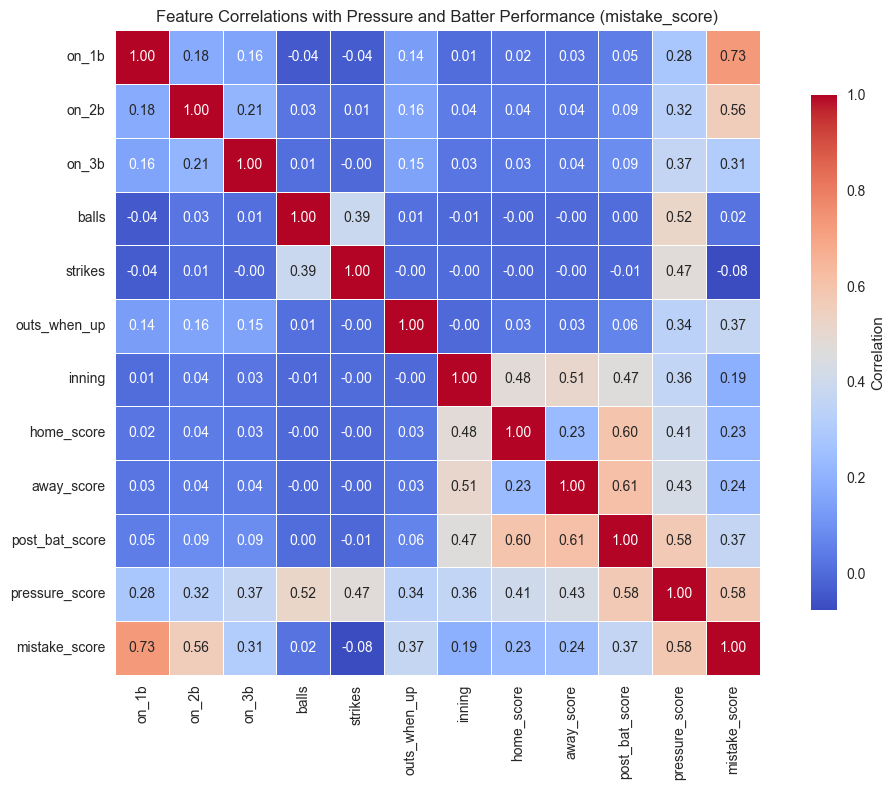

C:\Users\wangr\AppData\Local\Temp\ipykernel_32400\319428549.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_values.values, y=corr_values.index, palette="viridis")


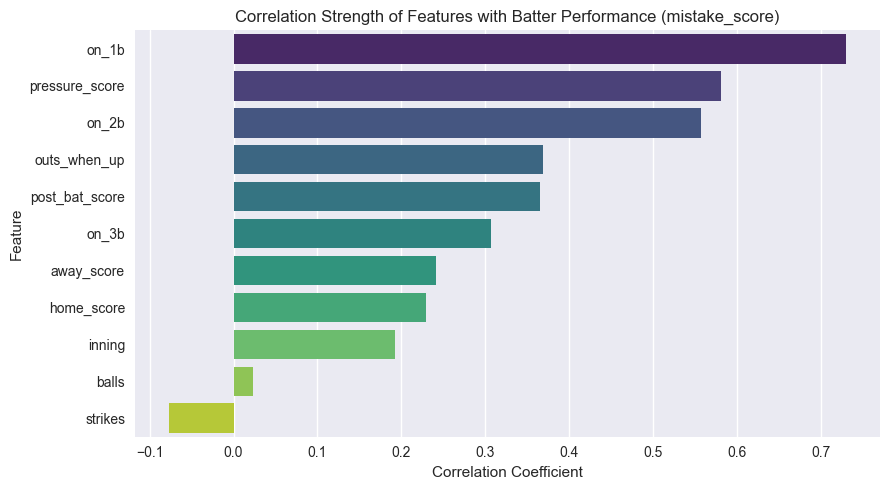

C:\Users\wangr\AppData\Local\Temp\ipykernel_32400\319428549.py:111: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\wangr\AppData\Local\Temp\ipykernel_32400\319428549.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


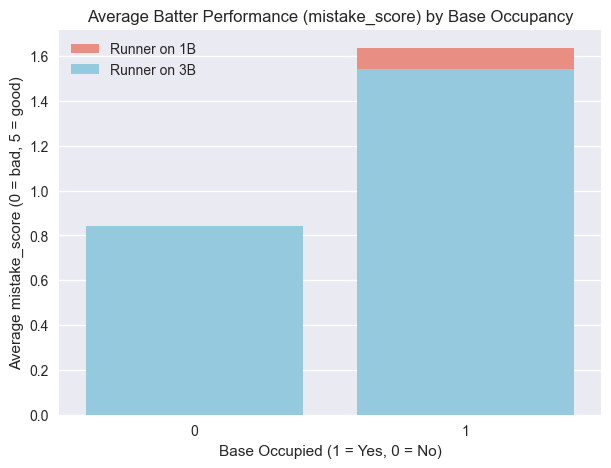

In [ ]:
# --- 4. Define 'mistake_score' using a data-driven model (0–5 scale) ---

# Step 1: compute the true outcome change
df["run_delta"] = df["post_bat_score"].fillna(0) - df["bat_score"].fillna(0)

# Step 2: choose contextual features for performance learning
features_for_score = [
    "balls", "strikes", "outs_when_up",
    "on_1b", "on_2b", "on_3b",
    "pressure_score"
]

# Drop rows missing required features
train_df = df.dropna(subset=features_for_score + ["run_delta"]).copy()

# Ensure all features are numeric
for col in features_for_score + ["run_delta"]:
    train_df[col] = pd.to_numeric(train_df[col], errors="coerce")

# Filter out rows where run_delta is constant (e.g., all zeros)
train_df = train_df[train_df["run_delta"] != 0]

# Check for sufficient variation
if len(train_df) < 20 or train_df["run_delta"].std() == 0:
    print("Warning: Insufficient variation in run_delta. Mistake score may be flat.")
    df["mistake_score"] = 2.5
else:
    X_score = train_df[features_for_score].fillna(0)
    y_score = train_df["run_delta"]

    # Step 3: train a simple linear regression to learn contribution patterns
    linreg = LinearRegression()
    linreg.fit(X_score, y_score)

    # Step 4: predict continuous batter performance for all rows
    df["predicted_run_delta"] = linreg.predict(df[features_for_score].fillna(0))

    # Add a positive boost for rows where the batter actually scored
    # so these stand out at the top end of the scale
    df.loc[df["run_delta"] > 0, "predicted_run_delta"] += 0.5

    # Step 5: scale predictions to 0–5 range
    pred_min, pred_max = df["predicted_run_delta"].min(), df["predicted_run_delta"].max()
    if np.isclose(pred_min, pred_max):
        print("Warning: Predicted run_delta values have no variation. Using constant midpoint (2.5).")
        df["mistake_score"] = 2.5
    else:
        scaler = MinMaxScaler(feature_range=(0, 5))
        df["mistake_score"] = scaler.fit_transform(df[["predicted_run_delta"]])

    # Optional: inspect learned weights
    coef_table = pd.DataFrame({
        "Feature": features_for_score,
        "Weight": linreg.coef_
    }).sort_values("Weight", ascending=False)

    print("\nLearned feature influence on batter performance:")
    display(coef_table)

# --- Diagnostic summary ---
print("\nMistake score summary:")
print(df["mistake_score"].describe())


# -----------------------------------------------------------------
# --- Heatmap: Correlation Between Key Game Variables -------------
# -----------------------------------------------------------------

corr_features = [
    "on_1b","on_2b","on_3b","balls","strikes",
    "outs_when_up","inning","home_score","away_score",
    "post_bat_score","pressure_score","mistake_score"
]

# Clean numeric data
heatmap_df = df[corr_features].apply(pd.to_numeric, errors="coerce").dropna()

plt.figure(figsize=(11,8))
sns.heatmap(
    heatmap_df.corr(),
    annot=True, cmap="coolwarm", fmt=".2f",
    linewidths=0.5, square=True,
    cbar_kws={"shrink":0.8, "label":"Correlation"}
)
plt.title("Feature Correlations with Pressure and Batter Performance (mistake_score)")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# --- Correlation Strength Bar Graph ------------------------------
# -----------------------------------------------------------------

# Compute correlations relative to mistake_score
corr_values = heatmap_df.corr()["mistake_score"].drop("mistake_score").sort_values(ascending=False)

plt.figure(figsize=(9,5))
sns.barplot(x=corr_values.values, y=corr_values.index, palette="viridis")
plt.title("Correlation Strength of Features with Batter Performance (mistake_score)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



C:\Users\wangr\AppData\Local\Temp\ipykernel_32400\2093618134.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


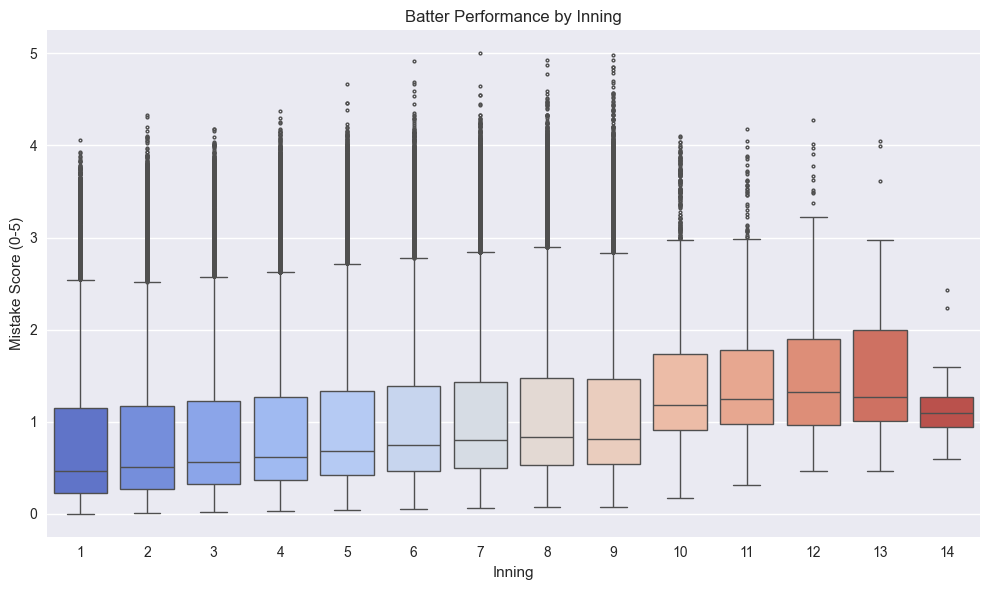

In [5]:
plt.figure(figsize=(10,6))
sns.boxplot(
    x="inning", y="mistake_score",
    data=df, palette="coolwarm", fliersize=2
)
plt.title("Batter Performance by Inning")
plt.xlabel("Inning")
plt.ylabel("Mistake Score (0-5)")
plt.tight_layout()
plt.show()

C:\Users\wangr\AppData\Local\Temp\ipykernel_32400\3258792179.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("pressure_bin")


,pressure_bin,total_points,avg_points,earned_count,no_point_count,sample_count
0,0-16.7 (Very Low),2031,0.008142,1829,247632,249461
1,16.7-33.3 (Low),9367,0.026994,7521,339480,347001
2,33.3-50.0 (Mid-Low),7817,0.081965,5641,89729,95370
3,50.0-66.7 (Mid-High),1615,0.176060,1060,8113,9173
4,66.7-83.3 (High),135,0.261628,86,430,516
5,83.3-100 (Very High),7,0.194444,3,33,36


C:\Users\wangr\AppData\Local\Temp\ipykernel_32400\3258792179.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


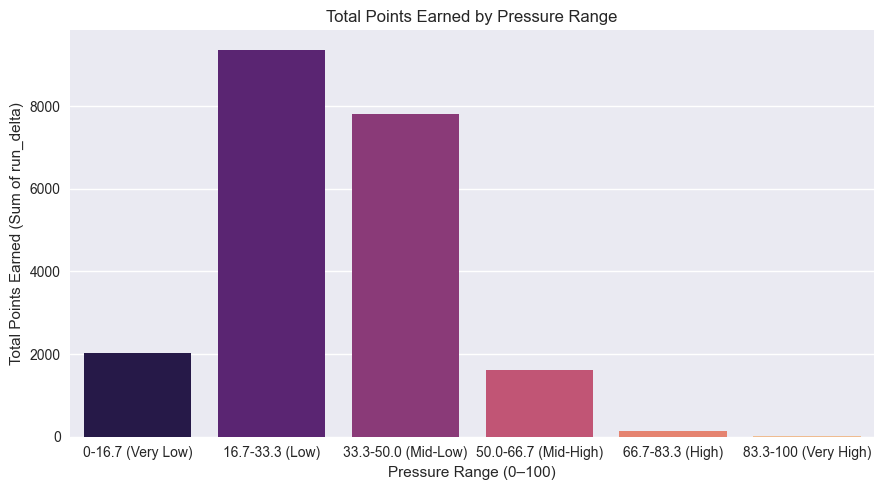

C:\Users\wangr\AppData\Local\Temp\ipykernel_32400\3258792179.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("pressure_bin")


,pressure_bin,failed_contacts
0,0-16.7 (Very Low),184229
1,16.7-33.3 (Low),226291
2,33.3-50.0 (Mid-Low),55869
3,50.0-66.7 (Mid-High),4945
4,66.7-83.3 (High),265
5,83.3-100 (Very High),22


C:\Users\wangr\AppData\Local\Temp\ipykernel_32400\3258792179.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


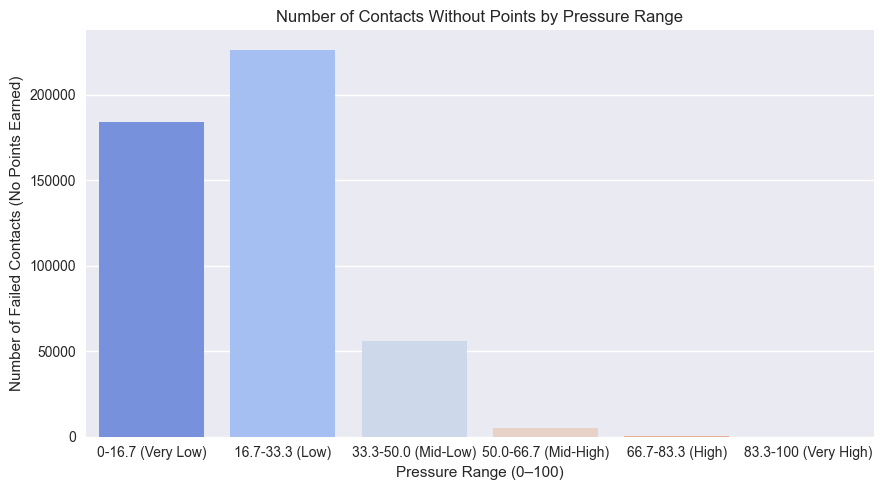

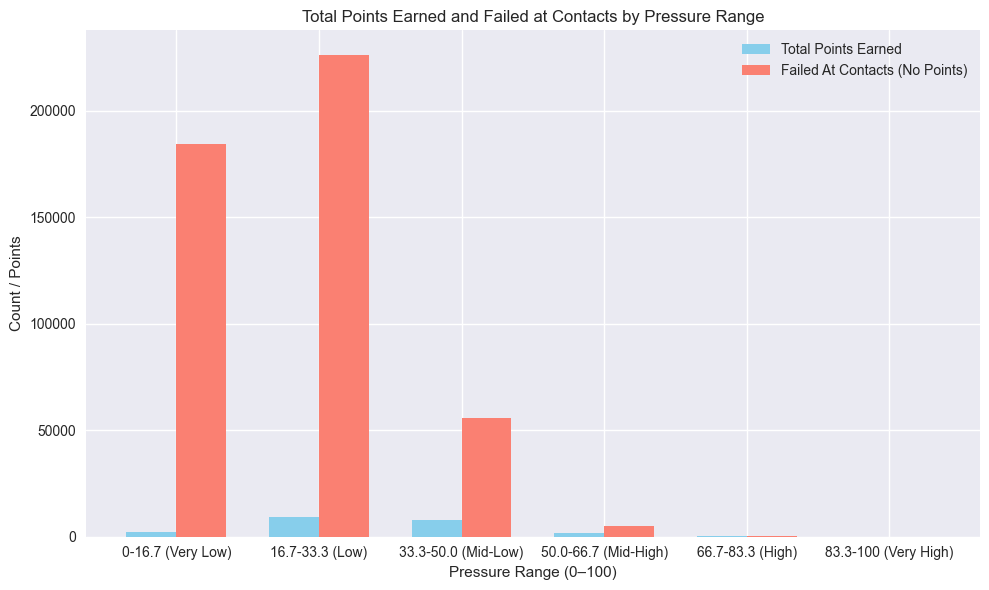

In [6]:
# --- 13. Total Points Earned vs. No-Point Plays by Pressure Range ---

# Filter valid rows (exclude NaN run_delta)
pressure_points_df = df[df["run_delta"].notna()].copy()

# Create pressure bins (0–100 divided into 6 equal ranges)
pressure_bins = [0, 16.67, 33.33, 50.0, 66.67, 83.33, 100]
pressure_labels = [
    "0-16.7 (Very Low)", 
    "16.7-33.3 (Low)", 
    "33.3-50.0 (Mid-Low)", 
    "50.0-66.7 (Mid-High)", 
    "66.7-83.3 (High)", 
    "83.3-100 (Very High)"
]

pressure_points_df["pressure_bin"] = pd.cut(
    pressure_points_df["pressure_score"],
    bins=pressure_bins,
    labels=pressure_labels,
    include_lowest=True
)


# Add a binary flag for whether a point was earned
pressure_points_df["earned_point"] = (pressure_points_df["run_delta"] > 0).astype(int)

# Group by pressure range
pressure_summary = (
    pressure_points_df
    .groupby("pressure_bin")
    .agg(
        total_points=("run_delta", "sum"),
        avg_points=("run_delta", "mean"),
        earned_count=("earned_point", "sum"),   # count of times a point was earned
        no_point_count=("earned_point", lambda x: (x == 0).sum()),  # count of no-point outcomes
        sample_count=("run_delta", "count")
    )
    .reset_index()
)

# Display summary table
display(pressure_summary)

# --- Plot 1: Total Points Earned by Pressure Range ---
plt.figure(figsize=(9,5))
sns.barplot(
    x="pressure_bin", y="total_points",
    data=pressure_summary, palette="magma"
)
plt.title("Total Points Earned by Pressure Range")
plt.xlabel("Pressure Range (0–100)")
plt.ylabel("Total Points Earned (Sum of run_delta)")
plt.tight_layout()
plt.show()





# --- Additional: Number of Contacts Without Points by Pressure Range ---

# Define what counts as a "hit/contact"
exclude_keywords = [
    "foul", "swinging_strike", "swinging_strike_blocked",
    "strikeout", "missed_bunt", "foul_tip"
]
mask_contact = ~pressure_points_df["description"].str.lower().str.contains("|".join(exclude_keywords), na=False)

# Filter: batter made contact but earned no points
contact_no_points_df = pressure_points_df[
    (mask_contact) & 
    (pressure_points_df["run_delta"] == 0)
].copy()

# Group by pressure range
fail_summary = (
    contact_no_points_df
    .groupby("pressure_bin")
    .size()
    .reset_index(name="failed_contacts")
)

# Merge with pressure summary to ensure consistent order of bins
# fail_summary = pressure_summary[["pressure_bin"]].merge(fail_summary, on="pressure_bin", how="left").fillna(0)
fail_summary = (
    pressure_summary[["pressure_bin"]]
    .merge(fail_summary, on="pressure_bin", how="left")
)
fail_summary["failed_contacts"] = fail_summary["failed_contacts"].fillna(0).astype(int)

# Display table
display(fail_summary)

# --- Plot failed contact frequency by pressure ---
plt.figure(figsize=(9,5))
sns.barplot(
    x="pressure_bin", y="failed_contacts",
    data=fail_summary, palette="coolwarm"
)
plt.title("Number of Contacts Without Points by Pressure Range")
plt.xlabel("Pressure Range (0–100)")
plt.ylabel("Number of Failed Contacts (No Points Earned)")
plt.tight_layout()
plt.show()




# combine the two above graph into one bar
# --- Plot: Total Points Earned and Failed Contacts by Pressure Range ---
plt.figure(figsize=(10,6))
width = 0.35  # width of the bars
x = np.arange(len(pressure_summary["pressure_bin"]))  # label locations
plt.bar(x - width/2, pressure_summary["total_points"], width, label='Total Points Earned', color='skyblue')
plt.bar(x + width/2, fail_summary["failed_contacts"], width, label='Failed At Contacts (No Points)', color='salmon')
plt.title("Total Points Earned and Failed at Contacts by Pressure Range")
plt.xlabel("Pressure Range (0–100)")
plt.ylabel("Count / Points")
plt.xticks(x, pressure_summary["pressure_bin"])
plt.legend()
plt.tight_layout()
plt.show()
